# BCD Coverage Planning

## 1. convert image space to vector space

import packages: 

In [209]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

define the coverage paramters:

In [210]:
file_path = 'maps/grid_map2.pgm'
# start = (100, 50)
start = (20, 50)
sweep_angle = -np.pi/2 # -pi/2 to pi/2
sweep_interval = 4
retreat_dist = 10

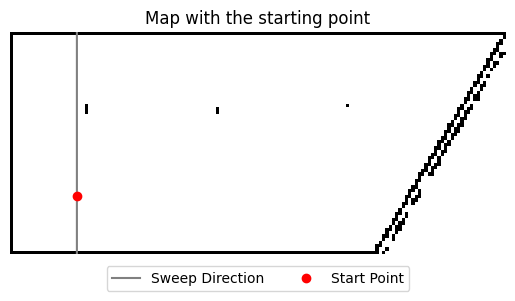

In [211]:
# Load the image
image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

# Plot the sweep_angle
line_p_factor = 3000
line_x = np.linspace(start[0] - line_p_factor*np.cos(sweep_angle), start[0] + line_p_factor*np.cos(sweep_angle), line_p_factor)
line_y = np.linspace(start[1] - line_p_factor*np.sin(sweep_angle), start[1] + line_p_factor*np.sin(sweep_angle), line_p_factor)

plt.plot(line_x, line_y, 'grey', label='Sweep Direction')


# Display the image
plt.plot(start[0], start[1], 'ro', label='Start Point')
plt.title("Map with the starting point")
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.show()

inflate the map

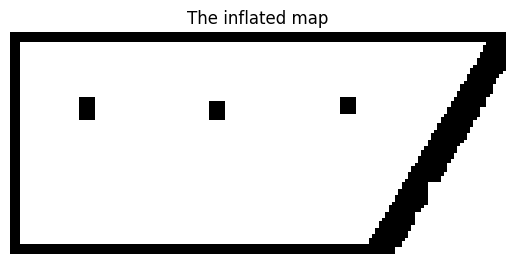

In [212]:
# convert the image to binary
ret, binary = cv2.threshold(image, 200, 255, cv2.THRESH_BINARY)

# errode the map 
erode_width = 5
erode_height = 5
element = cv2.getStructuringElement(cv2.MORPH_RECT, (erode_width, erode_height))
inflated_map = cv2.erode(binary, element)

# Display the result
plt.imshow(inflated_map, cmap='gray')
plt.title("The inflated map")
plt.axis('off')
plt.show()

get the interesting contours:

1. get the minimum area contour that contain the starting point
2. get all the obstacle contours that are inside the minimum area contour
3. reduce the number of points in the contours
4. the remaining key points in the contour makes the contour a polygon in vector space

Number of obstables:  3


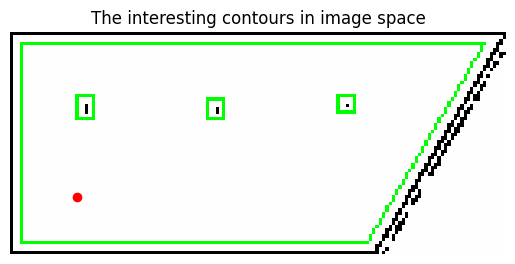

the image space and the vector space have different coordinate system


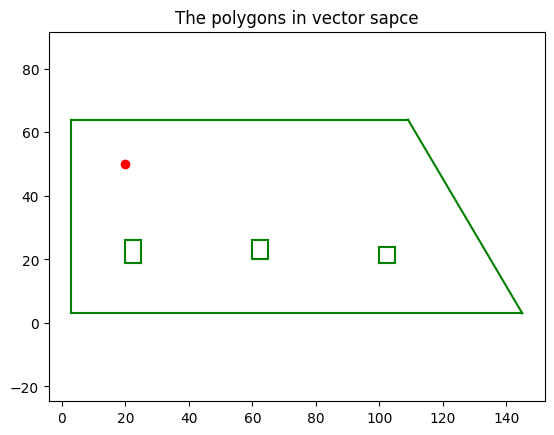

In [213]:

def find_interesting_contour(gray_map, current_pos):
    contours, hierarchy = cv2.findContours(gray_map, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # data structure for contours: list of numpy array shaped (n, 1, 2)

    minContour = None
    allChildContours = []
    minArea = None
    
    index = 0
    for i, contour in enumerate(contours):
        if cv2.pointPolygonTest(contour, current_pos, False) >= 0:
            area = cv2.contourArea(contour)
            if minContour is None or area < minArea:
                minArea = area
                minContour = contour
                index = i
                
    def find_all_child_contours(contours, hierarchy, parentIdx, childContours):
        if parentIdx < 0 or parentIdx >= len(hierarchy[0]):
            return
        childIdx = hierarchy[0][parentIdx][2]
        while childIdx != -1:
            childContours.append(contours[childIdx])
            find_all_child_contours(contours, hierarchy, childIdx, childContours)
            childIdx = hierarchy[0][childIdx][0]
    
    find_all_child_contours(contours, hierarchy, index, allChildContours)
    selected_contours = [minContour] + allChildContours
    
    # simplify the contours
    simplified_contours = []
    for cnt in selected_contours:
        epsilon = 0.02 * cv2.arcLength(cnt, True)  # Increased epsilon for more simplification
        simplified_contour = cv2.approxPolyDP(cnt, epsilon, True)
        simplified_contours.append(simplified_contour)
       
    def merge_close_points(contour, distance_threshold):
        """
        Merge points in a contour that are closer than the specified distance threshold.
        """
        if len(contour) <= 3:
            return contour

        merged_contour = []
        i = 0
        while i < len(contour):
            current_point = contour[i]
            next_point = contour[(i + 1)%len(contour)]
            distance = np.linalg.norm(current_point - next_point)
            i += 1 # Normal iteration
            if distance < distance_threshold:
                merged_point = (current_point + next_point) / 2 # Convert numpy array to list
                if(i == len(contour)): # merge the last point with the first point
                    merged_contour[0] = merged_point
                else:
                    merged_contour.append(merged_point)
                i += 1 # Skip the next point
            else:
                merged_contour.append(current_point.tolist())  # Convert numpy array to list
            # print(current_point, next_point, distance, np.array(merged_contour[-1], dtype=np.int32))

        return np.array(merged_contour, dtype=np.int32)
    
    distance_threshold = 2
    merged_contours = [merge_close_points(cnt, distance_threshold) for cnt in simplified_contours]
    
    return merged_contours

selected_contours = find_interesting_contour(inflated_map, start)
print("Number of obstables: ", len(selected_contours)-1)

# for cnt in selected_contours:
#     print("Number of points in contour: ", len(cnt))

# display the result
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  

contour_board = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
cv2.drawContours(contour_board, selected_contours, -1, (0, 255, 0), 1)
# display the vertices
# for cnt in selected_contours:
#     for point in cnt:
#         plt.plot(point[0][0], point[0][1], 'ro')
plt.imshow(cv2.cvtColor(contour_board, cv2.COLOR_BGR2RGB))
plt.plot(start[0], start[1], 'ro')
plt.axis('off')
plt.title('The interesting contours in image space')
plt.show()

print("the image space and the vector space have different coordinate system")

def plt_draw_contour(contour, color='green'):
    n = len(contour)
    for i in range(n):
        plt.plot([contour[i][0][0], contour[(i+1)%n][0][0]], 
                 [contour[i][0][1], contour[(i+1)%n][0][1]], color)
        
for cnt in selected_contours:
    plt_draw_contour(cnt, 'green')

plt.plot(start[0], start[1], 'ro')
plt.title('The polygons in vector sapce')
plt.axis('equal')
plt.show()

## 2. decompose the map then do coverage

sort the orientation of the polygon in Counter-clockwise order

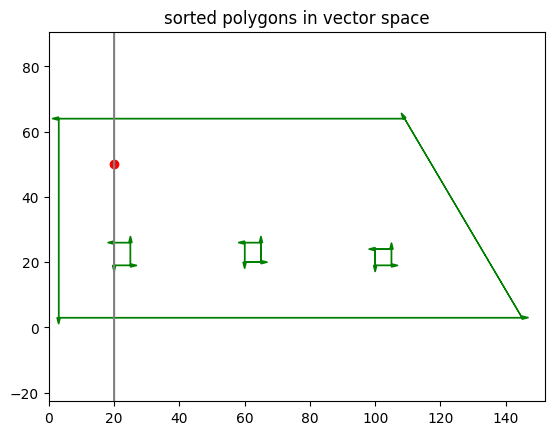

In [214]:
def sort_polygon(contour):
    area = 0
    n = len(contour)

    for i in range(n):
        j = (i + 1) % n
        area += contour[i][0][0] * contour[j][0][1]
        area -= contour[j][0][0] * contour[i][0][1]

    area /= 2.0

    if area <= 0: # if "clockwise"
        return contour[::-1] # reverse the order
    else:
        return contour

sorted_polygons = []
for contour in selected_contours:
    sorted_polygon = sort_polygon(contour)
    sorted_polygons.append(sorted_polygon)

def plt_draw_arrow_contour(contour, color='green'):
    n = len(contour)
    for i in range(n):
        plt.arrow(contour[i][0][0], contour[i][0][1], 
                  contour[(i+1)%n][0][0] - contour[i][0][0], 
                  contour[(i+1)%n][0][1] - contour[i][0][1], 
                  color=color, head_width=1, head_length=2)

# display the result
for poly in sorted_polygons:
    plt_draw_arrow_contour(poly, 'green')

plt.title('sorted polygons in vector space')
plt.plot(start[0], start[1], 'ro')
plt.plot(line_x, line_y, 'grey')
plt.axis('equal')
plt.xlim([0, image.shape[1]])
plt.ylim([0, image.shape[0]])
plt.show()

rotate the polygons to make the sweep direction alaign with the y-axis, and the left most point of the polygon is the starting point

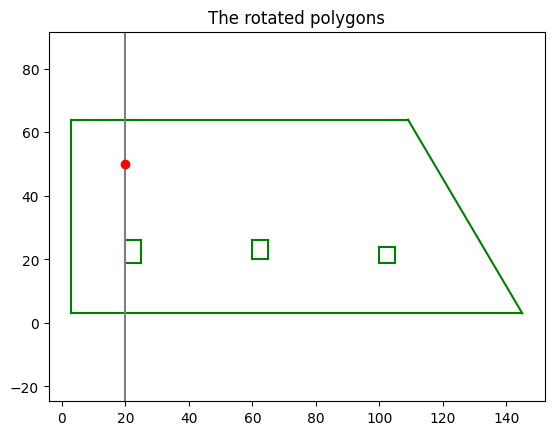

In [215]:
def rotate_point(point, angle, origin=(0, 0)):
    """
    Rotate a point counterclockwise by a given angle around a given origin.
    The angle should be given in radians.
    """
    ox, oy = origin
    px = point[0][0]
    py = point[0][1]
    qx = ox + np.cos(angle) * (px - ox) - np.sin(angle) * (py - oy)
    qy = oy + np.sin(angle) * (px - ox) + np.cos(angle) * (py - oy)
    return np.array([[qx, qy]])

def point_to_line_distance_and_side(point, line_point1, line_angle):
    # calculate the coefficients A, B, and C for the line equation
    A = np.sin(line_angle)
    B = -np.cos(line_angle)
    C = -A*line_point1[0] - B*line_point1[1]

    # calculate the distance from the point to the line
    distance = abs(A*point[0][0] + B*point[0][1] + C) / np.sqrt(A**2 + B**2)
    
    # use cross product to determine which side the point is on
    v1 = np.array([np.cos(line_angle), np.sin(line_angle)])
    v2 = point - line_point1
    cross_product = np.cross(v1, v2)
    
    side = 'left' if cross_product > 0 else 'right'
    
    return distance, side

left_max_dist = 0
right_max_dist = 0
for i in range(sorted_polygons[0].shape[0]):
    point = sorted_polygons[0][i]
    distance, side = point_to_line_distance_and_side(point, start, sweep_angle)
    
    if side == 'left':
        left_max_dist = max(left_max_dist, distance)
    else:
        right_max_dist = max(right_max_dist, distance)

rotate_angle = np.pi * 3 / 2 - sweep_angle
if left_max_dist < right_max_dist:
    print("Left side is closer")
    rotate_angle = np.pi/2 - sweep_angle

rotated_polygons = []
for polygon in sorted_polygons:
    rotated_poly = np.array([rotate_point(point, rotate_angle, start) for point in polygon])
    rotated_polygons.append(rotated_poly)        
    plt_draw_contour(rotated_poly, 'green')


plt.title('The rotated polygons')
plt.axvline(x=start[0], color='grey')
plt.plot(start[0], start[1], 'ro')
plt.axis('equal')
plt.show()


start sweeping:
1. sort the vertices of the polygon in ascending order of x-axis
2. sweep from left to right
3. maintain a graph of decomposed polygons
4. based on rule at the cirtical point to decompose the polygon

<div align="center">
  <img src="asset/incremental_coverage.png" alt="incremental_coverage" width="800">
</div>

<div align="center">
  <img src="asset/cirtical_point.png" alt="cirtical_point" width="800">
</div>

Stage 1 ~ 3

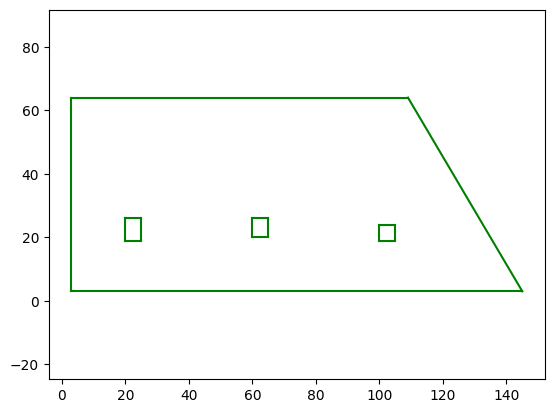

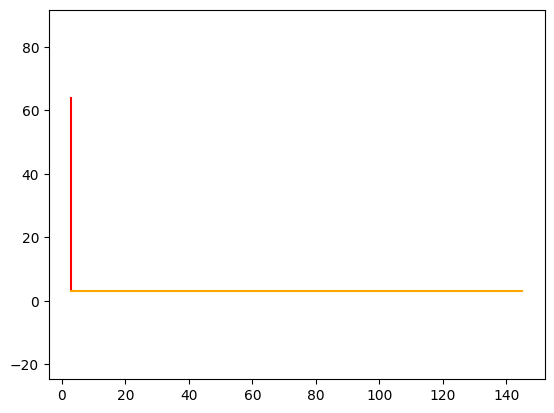

length of edges: 1
y_dist is: -60.99999999999999, j is 0
j is:  -1
MIDDLE


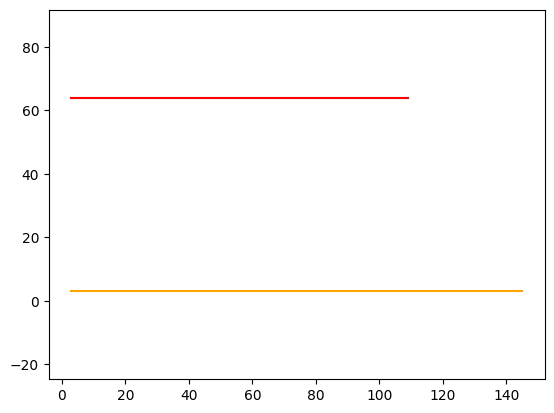

length of edges: 2
y_dist is: 45.0, j is 0
y_dist is: -15.999999999999996, j is 1
j is:  0
MIDDLE


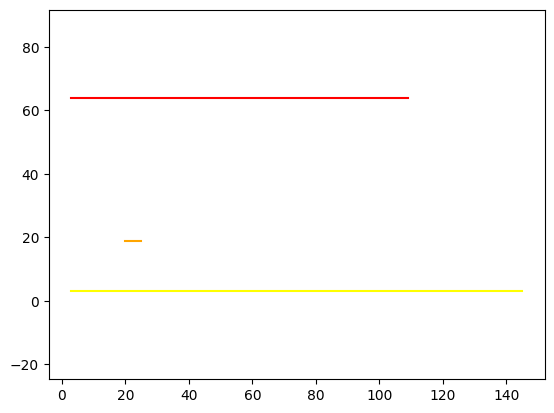

length of edges: 3
y_dist is: 38.0, j is 0
y_dist is: -7.0, j is 1
j is:  0
MIDDLE


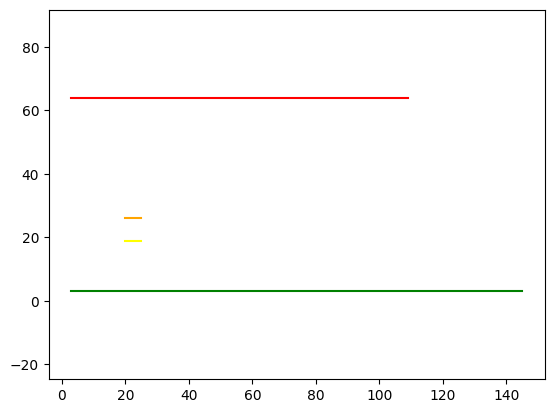

MIDDLE


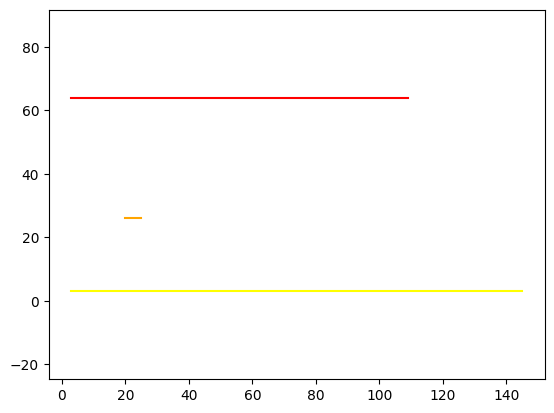

MIDDLE


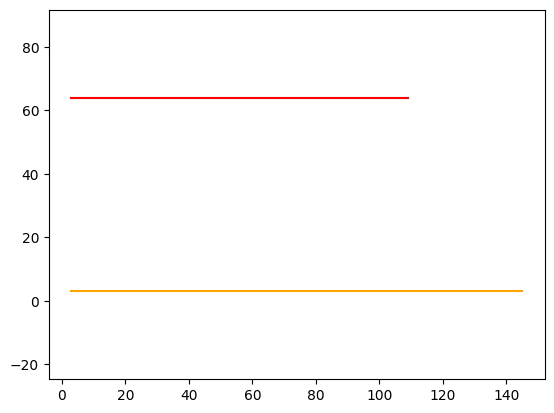

length of edges: 2
y_dist is: 43.99999999999999, j is 0
y_dist is: -17.0, j is 1
j is:  0
MIDDLE


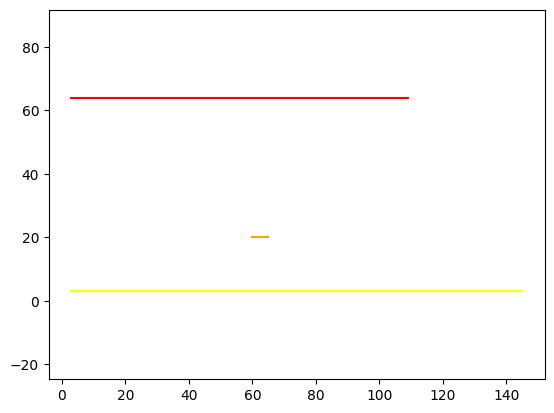

length of edges: 3
y_dist is: 37.99999999999999, j is 0
y_dist is: -6.0, j is 1
j is:  0
MIDDLE


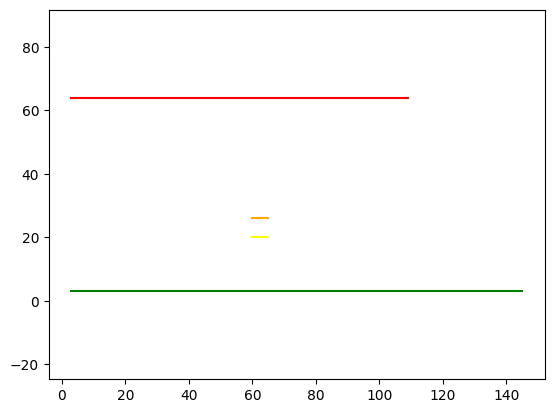

length of edges: 3
y_dist is: 44.0, j is 0
y_dist is: 6.0, j is 1
y_dist is: -16.999999999999993, j is 2
j is:  1
MIDDLE


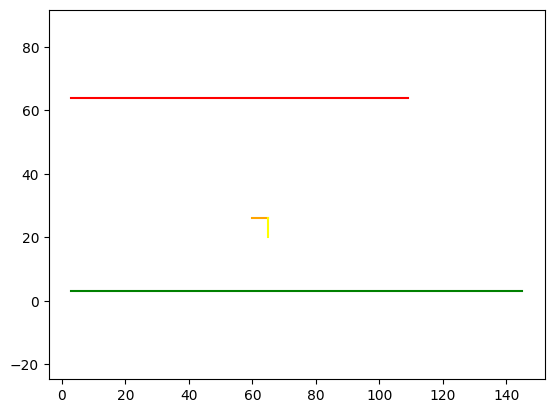

OUT


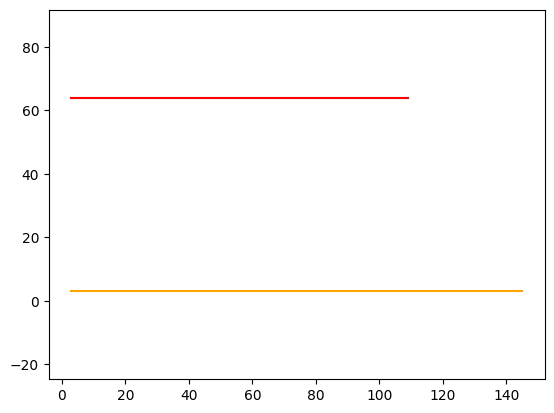

y_dist is: 45.0, j is 0
y_dist is: -15.999999999999996, j is 1
j is:  0
IN


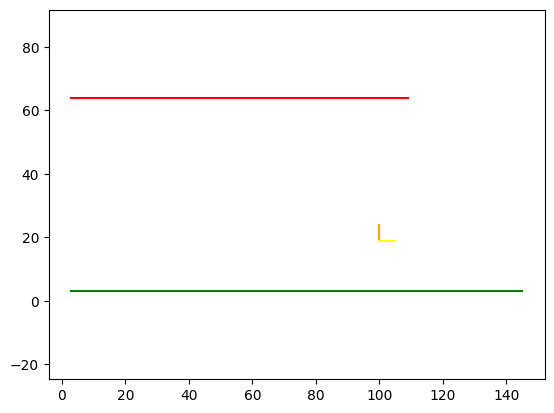

length of edges: 3
y_dist is: 40.0, j is 0
y_dist is: -5.0, j is 1
j is:  0
MIDDLE


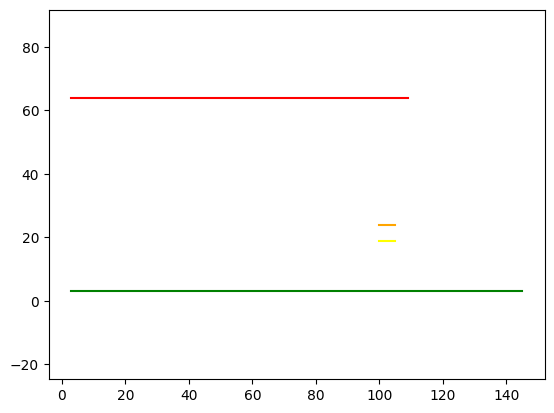

length of edges: 3
y_dist is: 45.0, j is 0
y_dist is: 5.0, j is 1
y_dist is: -15.999999999999996, j is 2
j is:  1
MIDDLE


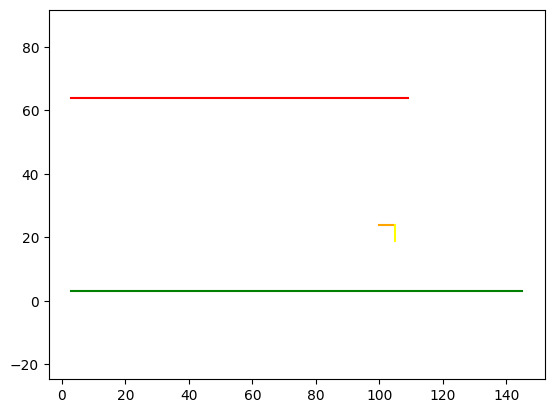

OUT


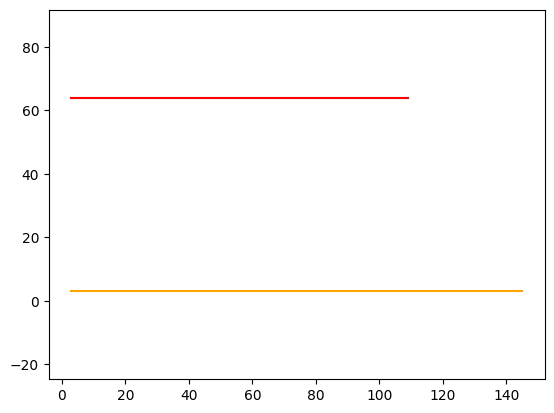

length of edges: 1
y_dist is: -61.0, j is 0
j is:  -1
MIDDLE


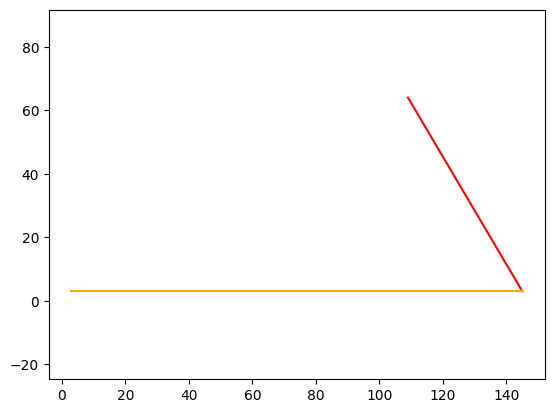

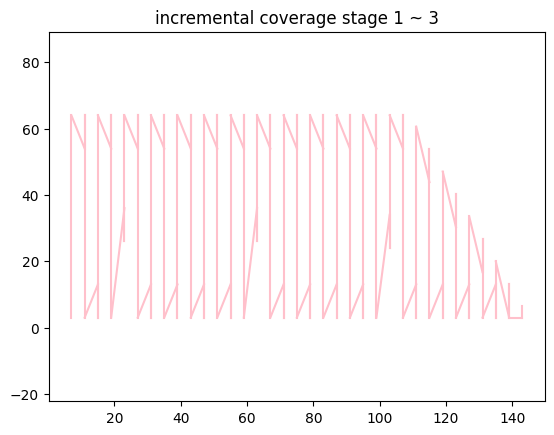

In [216]:
vertices = [] # list of pointers shaped (2, 1)
for i in range(len(rotated_polygons)):
    for j in range(len(rotated_polygons[i])):
        vertices.append(np.array([i, j]))

def get_point_from_polygons(double_index):
    return rotated_polygons[double_index[0]][double_index[1]][0]

# sort the vertices by x value
sorted_vertices = sorted(vertices, key=lambda v: get_point_from_polygons(v)[0])

# Get the intersection of a vertical line and an edge(line segment)
def get_intersection(x, edge):  
    point1, point2 = edge
    if x < min(point1[0], point2[0]) or x > max(point1[0], point2[0]):
        return None
    
    # if the edge is vertical
    if point1[0] == point2[0]:
        return None
    
    t = (x - point1[0]) / (point2[0] - point1[0])
    y = point1[1] + t * (point2[1] - point1[1])
    return np.array([x, y])

tau = 1e-3

def get_closest_edge_index(p_curr, edges):
    for j in range(len(edges)):
        intersection = get_intersection(p_curr[0], edges[j])
        if intersection is not None:
            y_dist = intersection[1] - p_curr[1]
            print(f"y_dist is: {y_dist}, j is {j}")
            if y_dist < -tau:
                return j-1

# plot the rotated polygons
for poly in rotated_polygons:
    plt_draw_contour(poly, 'green')

edges = [] # list of np.array shaped (2, 2)
path = []
reverse = True
channel_index = 0 
state = ""
not_selected_edge_group = []
cur_sweep_x = get_point_from_polygons(sorted_vertices[0])[0]

i = 0
while i < len(sorted_vertices):
    cur_vertex_x = get_point_from_polygons(sorted_vertices[i])[0]
    
    # process the next vertex
    if cur_sweep_x + sweep_interval >= cur_vertex_x:
        # >>> for debug
        colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink']
        l = 0
        for edge in edges:
            plt.plot([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]], colors[l])
            l += 1
        print(state)
        plt.axis('equal')
        plt.show() 
        # <<< for debug
        
        cur_poly_index = sorted_vertices[i][0]
        cur_pt_index = sorted_vertices[i][1]
        points_num = len(rotated_polygons[cur_poly_index])
        
        p_curr = rotated_polygons[cur_poly_index][cur_pt_index][0]
        p_next = rotated_polygons[cur_poly_index][(cur_pt_index+1)%points_num][0]
        p_prev = rotated_polygons[cur_poly_index][(cur_pt_index-1)%points_num][0]
        
        upper_edge = [p_curr, p_next]
        lower_edge = [p_curr, p_prev]
        if (p_next[1] <= p_prev[1]):
            upper_edge, lower_edge = lower_edge, upper_edge
        
        # insert the new edges to the edge list
        if len(edges) == 0:
            edges.append(upper_edge)
            edges.append(lower_edge)
        else:
            # decide the event type
            if p_next[0] > p_curr[0] and p_prev[0] > p_curr[0]: # IN
                state = "IN"
                
                # Find insert position
                j = get_closest_edge_index(p_curr, edges)
                print("j is: ", j)
                
                edges.insert(j+1, lower_edge)
                edges.insert(j+1, upper_edge)
                
            elif p_next[0] < p_curr[0] and p_prev[0] < p_curr[0]: # OUT
                state = "OUT"
                
                j = 0
                while j < len(edges):
                    intersection = get_intersection(p_curr[0], edges[j])
                    if intersection is not None:
                        y_dist = intersection[1] - p_curr[1]
                        if y_dist < tau and y_dist > -tau:
                            edges.pop(j)
                            j -= 1
                    j += 1
                
                if len(edges) != 0:
                    pass
                    # plt.plot([p_curr[0], p_curr[0]], [p_curr[1]+min_neg_y, p_curr[1]+min_pos_y], 'pink')
                    
            else: # MIDDLE
                state = "MIDDLE"
                
                edge_vertix = [p_prev, p_next]
                # sort the edge_vertix by x value
                edge_vertix = sorted(edge_vertix, key=lambda v: v[0])
                
                left_edge = [p_curr, edge_vertix[0]]

                    
                j = 0
                while j < len(edges):
                    if edges[j][0][0] == left_edge[1][0] and \
                       edges[j][1][0] == left_edge[0][0] and \
                       edges[j][0][1] == left_edge[1][1] and \
                       edges[j][1][1] == left_edge[0][1] :
                            edges.pop(j)
                    j += 1    
                    
                if edge_vertix[1][0] > p_curr[0]:
                    right_edge = [p_curr, edge_vertix[1]]
                    print(f"length of edges: {len(edges)}")
                    j = get_closest_edge_index(p_curr, edges)
                    print("j is: ", j)
                    
                    edges.insert(j+1, right_edge)
                    
        # decide which channel to fill
        if len(path) > 0:
            j = 0
            max_channel_width = 0
            while j < len(edges) - 1:
                channel_width = get_intersection(p_curr[0], edges[j])[1] - get_intersection(p_curr[0], edges[j+1])[1]
                if channel_width > max_channel_width:
                    max_channel_width = channel_width
                    channel_index = j // 2
                j += 2  
                    
        i += 1

    # draw sweeping lines
    else:
        cur_sweep_x += sweep_interval
        intersections = []
        
        selected_edges = [edges[2*channel_index], edges[2*channel_index+1]]
        not_selected_edge_group =[]
        for edge in selected_edges:
                intersection = get_intersection(cur_sweep_x, edge)
                if intersection is not None:
                    intersections.append(intersection)
        
        if reverse:
            intersections.reverse()
            last_edge = selected_edges[0]
            reverse = False
        else:
            last_edge = selected_edges[1]
            reverse = True
            
        # draw the intersections
        if len(path) != 0 and abs(intersections[0][1] - intersections[1][1]) > retreat_dist:
            sign = -1 if intersections[0][1] > intersections[1][1] else 1
            retreat_point = np.array([cur_sweep_x, intersections[0][1] + sign*retreat_dist])
            path.append(retreat_point)
            
        path.append(intersections[0])
        path.append(intersections[1])

for i in range(len(path)-1):
    plt.plot([path[i][0], path[(i+1)][0]], [path[i][1], path[(i+1)][1]], 'pink')
    
plt.title('incremental coverage stage 1 ~ 3')
plt.axis('equal')
plt.show() 

Stage 4

rotate the path back

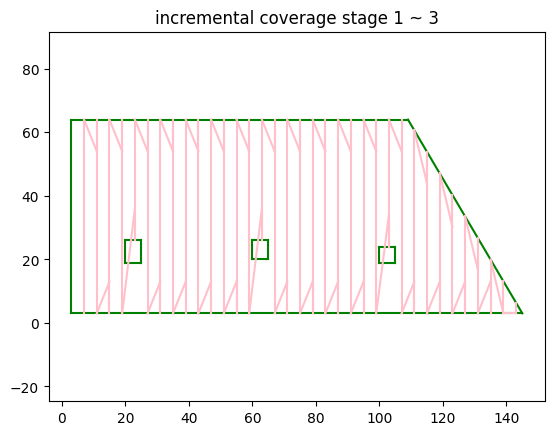

In [217]:
rotated_path = []
for point in path:
    p = rotate_point([point], -rotate_angle, start)
    rotated_path.append(p[0])

# plot the polygons
for poly in sorted_polygons:
    plt_draw_contour(poly, 'green')    

for i in range(len(rotated_path)-1):
    plt.plot([rotated_path[i][0], rotated_path[(i+1)][0]],\
        [rotated_path[i][1], rotated_path[(i+1)][1]], 'pink')
    
plt.title('incremental coverage stage 1 ~ 3')
plt.axis('equal')
plt.show()   